In [1]:
import pandas as pd
import numpy as np
import cvxopt
import pickle
import time
import gc
import matplotlib.pylab as plt
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import distance
from sklearn.metrics import accuracy_score

In [2]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        # Manejar el caso donde la desviación estándar es cero
        self.scale_[self.scale_ == 0] = np.finfo(float).eps  # Usar un valor pequeño en lugar de 0
        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("Scaler has not been fitted yet. Call fit() before transform().")
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [3]:
scaler = StandardScaler()
# Crear el codificador
le = LabelEncoder()

In [4]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None
        self.losses = []
        self.fit_times = []

    def hinge_loss(self, w, b, x, y):
        reg = 0.5 * np.dot(w, w.T)[0][0]
        loss = np.maximum(0, 1 - y * (np.dot(x, w.T) + b))
        hinge_loss = reg + self.C * np.sum(loss)
        return hinge_loss

    def fit(self, X, Y, learning_rate=0.01, epochs=1000):
        number_of_samples, number_of_features = X.shape
        self.w = np.random.randn(1, number_of_features) / np.sqrt(number_of_features)  # Inicialización de pesos
        self.b = 0

        for i in range(epochs):
            start_time = time.time()
            l = self.hinge_loss(self.w, self.b, X, Y)
            self.losses.append(l)

            gradw = np.zeros(self.w.shape)
            gradb = 0

            for j in range(number_of_samples):
                ti = Y[j] * (np.dot(self.w, X[j].reshape(-1, 1)) + self.b)

                if ti >= 1:
                    gradw += 0
                    gradb += 0
                else:
                    gradw += -self.C * Y[j] * X[j]
                    gradb += -self.C * Y[j]

            gradw += self.w / number_of_samples  # Regularización L2
            gradb /= number_of_samples

            self.w = self.w - learning_rate * (self.w + gradw)
            self.b = self.b - learning_rate * gradb

            end_time = time.time()
            self.fit_times.append(end_time - start_time)

            if (i + 1) % 100 == 0:
                print(f"Epoch {i+1}/{epochs}: Hinge Loss = {l:.4f}")

            # Diagnóstico de divergencia
            print(f"Weights at epoch {i+1}: {self.w}")
            print(f"Bias at epoch {i+1}: {self.b}")

        return self.w, self.b, self.losses, self.fit_times

    def predict(self, X_test):
        predictions = np.dot(X_test, self.w.T) + self.b
        binary_predictions = np.sign(predictions)
        return binary_predictions


In [5]:
def plot_learning_curve(svm, title, X, y, axes=None, ylim=None):
    """
    Genera una curva de aprendizaje simple.
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")

    # Obtén las pérdidas y los tiempos de ajuste de tu objeto svm
    losses = svm.losses
    fit_times = svm.fit_times

    # Gráfica de la curva de aprendizaje
    axes[0].grid()
    axes[0].plot(range(len(losses)), losses, 'o-', color="r", label="Training loss")
    axes[0].legend(loc="best")

    # Gráfica de n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(range(len(fit_times)), fit_times, 'o-')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Gráfica de fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times, losses, 'o-')
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Loss")
    axes[2].set_title("Performance of the model")

    return plt


In [6]:
try:
    with open('SVM3.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    print("Modelos cargados desde 'SVM.pkl'")
    # Ahora puedes usar 'loaded_model' en lugar de 'forest' y 'loaded_counter' en lugar de 'contador'
    svm_models = loaded_model
except FileNotFoundError:
    print("Archivo 'SVM.pkl' no encontrado. Se creará un nuevo")
    # Inicializar una lista para almacenar los modelos SVM
    svm_models = []

Archivo 'SVM.pkl' no encontrado. Se creará un nuevo


In [7]:
svm_models

[]

In [8]:
df_train = pd.read_csv('muestras/muestra_real4.csv')

In [9]:
df_train

,Marca de Tiempo [s],Marca de Tiempo [ μs ],Dirección de Bloque Lógico (LBA) de un sector de lectura,Tamaño de un bloque al que accede una muestra,Entropia_de_Shannon,Tipo de Archivo
0,1587350553,147991736,102725088,4096,0.995206,benigno
1,1589947607,532943794,44074136,4096,0.000000,benigno
2,1594104924,793729625,87600664,4096,0.995347,benigno
3,1598246546,81561923,82130272,4096,0.782752,benigno
4,1598235573,87178811,6542184,4096,0.425663,benigno
...,...,...,...,...,...,...
199995,1596679908,2391383,119834896,4096,0.032303,ransomware
199996,1598615133,795094020,2394144,4096,0.993337,ransomware
199997,1623819369,519384324,52997088,4096,0.995358,ransomware
199998,1589344039,532886750,6512504,4096,0.409014,ransomware


In [10]:
ransomware = df_train[df_train['Tipo de Archivo'] == 'ransomware']
benigno = df_train[df_train['Tipo de Archivo'] == 'benigno']

In [11]:
# Parámetros para la consulta de lotes
total_batches = 1
batch_size = 12000

In [12]:
from sklearn.model_selection import KFold

In [13]:
# Iterar sobre los lotes de datos
for i in range(total_batches):
    df_ransomware = ransomware.sample(n=batch_size)
    df_benigno = benigno.sample(n=batch_size)

    # Concatenar los lotes
    batch = pd.concat([df_ransomware, df_benigno], ignore_index=True)

    # Codificar la última columna categórica
    batch['Tipo de Archivo'] = le.fit_transform(batch['Tipo de Archivo'])

    print("Lotes concatenados en un solo DataFrame")

    # Aplicar StandardScaler a las características
    X = batch.iloc[:, :-1].values
    X = scaler.fit_transform(X)  # Usamos el scaler que definiste previamente

    # Obtener las etiquetas
    y = batch.iloc[:, -1].values
            
    svm = SVM(C=0.1)
    svm.fit(X, y, learning_rate=0.0001)
    svm_models.append(svm)

    # Imprimir información sobre el proceso
    print("Lote", i+1, "procesado. Número de registros por procesar:", len(batch))

    # Liberar memoria después de procesar el lote
    #del batch, X, y
    gc.collect()  # Recoge la basura para liberar memoria adicional

    print("Memoria liberada después de procesar el lote", i+1)

    # Después de procesar todos los lotes, guardas el modelo SVM entrenado y la lista de modelos SVM en un archivo.
    with open('SVM3.pkl', 'wb') as file:
        pickle.dump(svm, file)  # Guardar la lista de modelos SVM

    print("Modelo SVM y lista de modelos guardados en 'SVM.pkl' después de procesar todos los lotes.")
    


Lotes concatenados en un solo DataFrame
Weights at epoch 1: [[-0.24128082 -0.25947886 -0.52334489  0.25904824  0.01409714]]
Bias at epoch 1: 4.8362500000001665e-06
Weights at epoch 2: [[-0.24994629 -0.25876787 -0.49907433  0.26121633  0.00991057]]
Bias at epoch 2: 9.695416666666977e-06
Weights at epoch 3: [[-0.25869668 -0.25855624 -0.47541569  0.26341927  0.00560108]]
Bias at epoch 3: 1.4574166666667104e-05
Weights at epoch 4: [[-0.26755856 -0.25894663 -0.45243115  0.26566077  0.00112253]]
Bias at epoch 4: 1.9474583333333877e-05
Weights at epoch 5: [[-0.2765377  -0.25988047 -0.43005053  0.26793636 -0.0034534 ]]
Bias at epoch 5: 2.43941666666673e-05
Weights at epoch 6: [[-0.28559789 -0.26111294 -0.40797941  0.27022963 -0.00813749]]
Bias at epoch 6: 2.9323750000000717e-05
Weights at epoch 7: [[-0.29477765 -0.26299848 -0.38652002  0.27255773 -0.01294785]]
Bias at epoch 7: 3.4272916666667444e-05
Weights at epoch 8: [[-0.30402749 -0.2651852  -0.36535421  0.274902   -0.01778838]]
Bias at epo

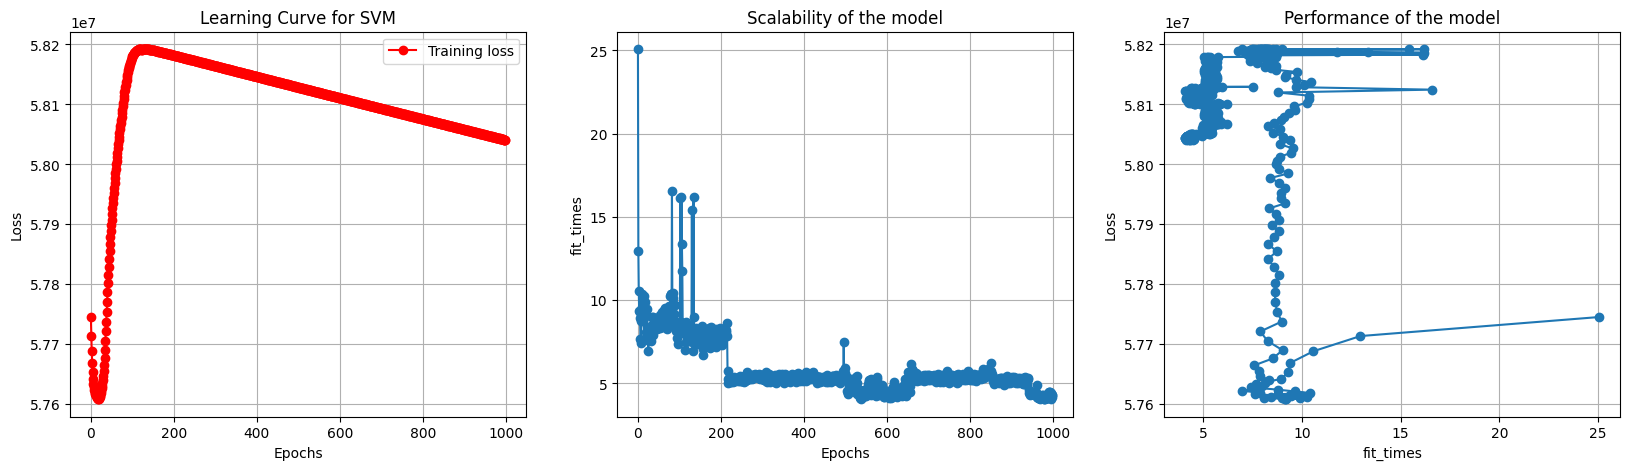

In [14]:
# Llama a la función plot_learning_curve con tu objeto svm
plot = plot_learning_curve(svm, "Learning Curve for SVM", X, y)

# Muestra las gráficas
plot.show()

In [15]:
svm_models

In [16]:
# Suponiendo que tienes un DataFrame de prueba llamado df_test
df_test = pd.read_csv('muestras/concatenado.csv')

In [17]:
# Preprocesar los datos de prueba
X_test = df_test.iloc[:, :-1].values
X_test = scaler.transform(X_test)  # Usar el escalador que ya ajustaste a tus datos de entrenamiento

In [18]:
y_test = le.transform(df_test.iloc[:, -1])   # Todas las filas, solo la última columna


In [19]:
# Usar la función para hacer predicciones con tu lista de modelos
y_pred = svm.predict(X_test)

In [20]:
y_pred[y_pred == -1] = 0


In [21]:
y_pred

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [22]:
accuracy = accuracy_score(y_test, y_pred)

# Calcular la precisión
print(f"Accuracy: ", accuracy)

Accuracy:  0.5708315789473685
